### Import Essential Libraries

In [1]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt

### Import Sklearn

In [2]:
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.datasets import load_iris, load_breast_cancer, load_wine

### Real Datasets

In [3]:
def get_australian_np():
    column_names = ["f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9", "f10", "f11", "f12", "f13", "f14", "label"]

    df = pd.read_csv("./Australian/australian.dat", delimiter=" ", header=None, names=column_names)
    data = df[["f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9", "f10", "f11", "f12", "f13", "f14"]]
    labels = df["label"]

    data = np.array(data)
    labels = np.array(labels)

    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    data = data.astype("float")
    
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = labels.astype("int")
    
    return data, labels

def load_Pendigits_np():
    data = np.loadtxt("./Pendigits/pendigits.tra.txt", delimiter=',')
    pendigits, labels = data[:, :-1], data[:, -1:]

    # Fix pendigits
    pendigits = pendigits.astype("float")
    scaler = MinMaxScaler()
    pendigits = scaler.fit_transform(pendigits)

    # Fix labels
    labels = np.squeeze(labels)
    labels = labels.astype("int")

    return pendigits, labels

def load_iris_np():
    iris = load_iris()
    X = MinMaxScaler().fit_transform(iris.data)
    y = iris.target
    return X, y

def load_wine_np():
    wine = load_wine()
    X = MinMaxScaler().fit_transform(wine.data)
    y = wine.target
    return X, y

def load_breast_cancer_np():
    breast_cancer = load_breast_cancer()
    X = MinMaxScaler().fit_transform(breast_cancer.data)
    y = breast_cancer.target
    return X, y

In [4]:
# Uncomment to select dataset

#X, y = load_iris_np()
#X, y = load_wine_np()
#X, y = load_breast_cancer_np()
#X, y = get_australian_np()
#X, y = load_Pendigits_np()

### Synthetic Datasets

In [5]:
def get_artificial2D(path, skiprows):
    full_path = "./Artificial/" + path
    df = pd.read_csv(full_path, skiprows=skiprows, names=['x', 'y', 'class'])
    labels = df["class"].to_numpy()
    label_enc = LabelEncoder()
    labels = label_enc.fit_transform(labels)
    df.drop(columns=["class"], inplace=True)
    data = df.to_numpy()
    
    return data, labels

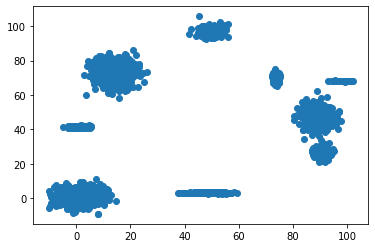

In [6]:
data_details = {
    0:("2d-4c-no4.arff", 10),
    1:("2d-10c.arff", 7),
    2:("aggregation.arff", 12),
    3:("D31.arff", 11),
    4:("impossible.arff", 10),
    4:("R15.arff", 10),
    7:("twenty.arff", 8),
}

# Select synthetic data set
data_id = 1
path, skiprows = data_details[data_id]
X, y = get_artificial2D(path, skiprows)

plt.scatter(X[:,0], X[:,1])
plt.show()

## The global k-means++ method

In [7]:
class Global_Kmeans_pp(BaseEstimator):
    def __init__(self, n_clusters=2, n_init=100, max_iter=300, tol=1e-4, sampling='k-means++', verbose=0):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.sampling = sampling
        self.verbose = verbose
        self.cluster_centers_ = OrderedDict()
        self.cluster_distance_space_ = OrderedDict()
        self.inertia_ = OrderedDict()
        self.labels_ = OrderedDict()
        
    def fit(self, X, y=None):
        kmeans = KMeans(n_clusters=1, init='random', n_init=1, tol=self.tol).fit(X)
        self.n_data = X.shape[0]
        self.cluster_centers_[1] = kmeans.cluster_centers_
        self.cluster_distance_space_[1] = kmeans.transform(X).min(axis=1)
        self.labels_[1] = kmeans.labels_
        self.inertia_[1] = kmeans.inertia_
        
        for k in range(2, self.n_clusters+1):
            if 0 < self.verbose: print('Solving {:d}-means'.format(k))
            centroid_candidates = self.__sampling(X, self.cluster_distance_space_[k-1])
                
            self.inertia_[k] = float('inf')
            for i, xi in enumerate(centroid_candidates): # TODO parallel
                current_centroids = np.vstack((self.cluster_centers_[k-1], xi))
                kmeans = KMeans(n_clusters=k, init=current_centroids, n_init=1, tol=self.tol)
                kmeans = kmeans.fit(X)
                
                if kmeans.inertia_ < self.inertia_[k]:
                    self.cluster_centers_[k] = kmeans.cluster_centers_
                    self.labels_[k] = kmeans.labels_
                    self.inertia_[k] = kmeans.inertia_
                    self.cluster_distance_space_[k] = kmeans.transform(X).min(axis=1)            
        return self
      
    def predict(self, X):
        return self.labels_, self.cluster_centers_, self.inertia_
    
    def transform(self, X):
        return self.cluster_distance_space_
    
    def __sampling(self, X, cluster_distance_space):
        if self.sampling == 'k-means++':
            _, selected_indexes = self.__kmeans_pp(X, cluster_distance_space)
            return X[selected_indexes]
        
        elif self.sampling == 'global':
            return X
        
        else:
            print("Wrong sampling method! options = ['k-means++', 'global']")
    
    def __kmeans_pp(self, X, cluster_distance_space):
        cluster_distance_space = np.power(cluster_distance_space, 2).flatten()
        sum_distance = np.sum(cluster_distance_space)
        selection_prob = cluster_distance_space / sum_distance
        selected_indexes = np.random.choice(self.n_data, size=self.n_init, p=selection_prob, replace=False)
        kmeans_pp_selected_centroids = X[selected_indexes]
        return kmeans_pp_selected_centroids, selected_indexes

### Global $k$-means++ example

In [8]:
# Select number of clusters K
n_clusters = 30

# Select number of candidates L 
n_init = 20

method = {0: 'k-means++', 1: 'global'}

# option=0 selects the global k-means++, option=1 selects the global k-means!
option = 0

# Same as in sklearn k-means method
tol = 1e-4
verbose = 1

global_kmeans_pp = Global_Kmeans_pp(n_clusters=n_clusters, n_init=n_init, tol=tol, sampling=method[option], verbose=verbose)
global_kmeans_pp.fit(X)
clusters, centroids, error = global_kmeans_pp.predict(X)
error

Solving 2-means
Solving 3-means
Solving 4-means
Solving 5-means
Solving 6-means
Solving 7-means
Solving 8-means
Solving 9-means
Solving 10-means
Solving 11-means
Solving 12-means
Solving 13-means
Solving 14-means
Solving 15-means
Solving 16-means
Solving 17-means
Solving 18-means
Solving 19-means
Solving 20-means
Solving 21-means
Solving 22-means
Solving 23-means
Solving 24-means
Solving 25-means
Solving 26-means
Solving 27-means
Solving 28-means
Solving 29-means
Solving 30-means


OrderedDict([(1, 6836698.757233148),
             (2, 3898375.020673314),
             (3, 1510418.259876268),
             (4, 904073.0998640165),
             (5, 478331.3507336376),
             (6, 291416.2200330839),
             (7, 155761.96304580764),
             (8, 84167.12213826716),
             (9, 52654.109695002575),
             (10, 46713.00003379921),
             (11, 41888.12419527724),
             (12, 37215.895173567056),
             (13, 32914.38412532853),
             (14, 29891.425976990606),
             (15, 27943.83030335251),
             (16, 26028.099344806058),
             (17, 24343.563156128897),
             (18, 22785.33294619294),
             (19, 21554.338880379903),
             (20, 20367.549897916168),
             (21, 19314.492639947446),
             (22, 18271.162981539088),
             (23, 17472.009290049537),
             (24, 16693.710585924615),
             (25, 16090.045016460383),
             (26, 15539.83448459848),
        

### Plot $k$-th clustering solution

In [9]:
def plot_solution(X, centroids, kmeans_labels, kmeans_centers):
    plt.figure(figsize=(10, 10), facecolor='white')
    plt.scatter(X[:,0], X[:,1], c=kmeans_labels)
    plt.scatter(kmeans_centers[:,0], kmeans_centers[:,1], c="r")
    plt.title("Clustering with {} centroids".format(centroids), fontsize=20)
    plt.show()
    plt.close()

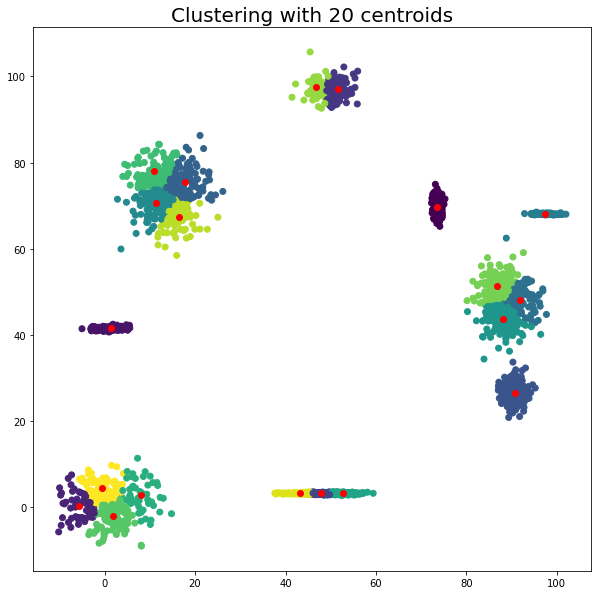

In [10]:
# Select k to plot solution which clustering solution you want to visualize
k = 20
plot_solution(X, "{:d}".format(k), clusters[k], centroids[k])